In [4]:
import hf_hydrodata as hf
import numpy as np

#q = - K * G * h
#X: (h2 - h1)/(x2-x1),(h_top - h_bot)/(y2-y1) 

def main():
    # Produced from https://hydro-dev.princeton.edu
    huc_list = [ "1404" ]
    ij_bounds = [1091, 1797, 1406, 2124]
    latlon_bounds = [40.5349012124,-110.9212757848, 43.4590985560,-107.0836798859]
    # # FOR CONUS1
    # options = {"dataset": "conus1_domain", "variable": "permeability"}
    # perm_np = hf.get_gridded_data(options)
    # print(perm_np.shape)
    # start_time = "2003-01-01"
    # end_time = "2003-01-02"
    # options = {"dataset": "conus1_baseline_mod", "variable": "pressure_head",
    #             "start_time" : start_time,
    #             "end_time" : end_time}
    # press_np = hf.get_gridded_data(options)
    # print(press_np.shape)

    
    # FOR CONUS2
    #pressure head
    start_time = "2003-01-01"
    end_time = "2003-01-02"
    options = {"dataset": "conus2_baseline", "variable": "pressure_head",
                "start_time" : start_time,
                "end_time" : end_time,
                "grid_bounds": ij_bounds
                }
    #Pressure has a format time, z, x,y going from low to high
    press_np = hf.get_gridded_data(options)
    print(press_np.shape)

    ##Constant variables throughout the simulation
    # permeability_x,y,z exists for conus2, but not conus1
    options = {"dataset": "conus2_domain", "variable": "permeability_x","grid_bounds": ij_bounds}
    perm_x = hf.get_gridded_data(options)
    print(perm_x.shape)
    options = {"dataset": "conus2_domain", "variable": "permeability_y","grid_bounds": ij_bounds}
    perm_y = hf.get_gridded_data(options)
    print(perm_y.shape)
    options = {"dataset": "conus2_domain", "variable": "permeability_z","grid_bounds": ij_bounds}
    perm_z = hf.get_gridded_data(options)
    print(perm_z.shape)
    options = {"dataset": "conus2_domain", "variable": "slope_x","grid_bounds": ij_bounds}
    slope_x = hf.get_gridded_data(options)
    print(slope_x.shape)
    options = {"dataset": "conus2_domain", "variable": "slope_y","grid_bounds": ij_bounds}
    slope_y = hf.get_gridded_data(options)
    print(slope_y.shape)
    options = {"dataset": "conus2_domain", "variable": "slope_y","grid_bounds": ij_bounds}
    slope_y = hf.get_gridded_data(options)
    print(slope_y.shape)
    options = {"dataset": "conus2_domain", "variable": "porosity","grid_bounds": ij_bounds}
    porosity = hf.get_gridded_data(options)
    print(porosity.shape)
    options = {"dataset": "conus2_domain", "variable": "porosity","grid_bounds": ij_bounds}
    porosity = hf.get_gridded_data(options)
    print(porosity.shape)
    #Max and minimum saturations
    options = {"dataset": "conus2_domain", "variable": "ssat","grid_bounds": ij_bounds}
    ssat = hf.get_gridded_data(options)
    print(ssat.shape)
    options = {"dataset": "conus2_domain", "variable": "sres","grid_bounds": ij_bounds}
    sres = hf.get_gridded_data(options)
    print(sres.shape)
    options = {"dataset": "conus2_domain", "variable": "vg_alpha","grid_bounds": ij_bounds}
    vg_alpha = hf.get_gridded_data(options)
    print(vg_alpha.shape)
    options = {"dataset": "conus2_domain", "variable": "vg_n","grid_bounds": ij_bounds}
    vg_n = hf.get_gridded_data(options)
    print(vg_n.shape)
    
    Delta_x = 1000 #1 km grid size in x direction
    Delta_y = 1000 #1 km grid size in y direction
    Delta_z = [200, 100, 50, 25, 10, 5, 1, 0.6, 0.3, 0.1] #cell thickness in vertical direction from bottom to top [m]
    return press_np,perm_x,perm_y,perm_z,slope_x,slope_y,porosity,Delta_x,Delta_y,Delta_z,ssat,sres,vg_alpha,vg_n

press_np,perm_x,perm_y,perm_z,slope_x,slope_y,porosity,Delta_x,Delta_y,Delta_z,ssat,sres,vg_alpha,vg_n = main()
    #hf.get_path

(24, 10, 327, 315)
(10, 327, 315)
(10, 327, 315)
(10, 327, 315)
(327, 315)
(327, 315)
(327, 315)
(10, 327, 315)
(10, 327, 315)
(10, 327, 315)
(10, 327, 315)
(10, 327, 315)
(10, 327, 315)


In [5]:
#calculate saturation and relative permeability using Van Genuchten model
#Saturation
sw_vG= lambda h,n: (ssat - sres)/((1 + np.abs(vg_alpha*h)**n)**(1-1/n))+sres #sw, head in cms
#Relative permeability
kr_vG= lambda h,n: (1-(np.abs(vg_alpha*h)**(n-1))/(1+np.abs(vg_alpha*h)**n)**(1-1/n))**2.0/((1 + np.abs(vg_alpha*h)**n)**((1-1/n)/2)) #kr

In [6]:
#Calculating saturation and relative permeability at all times since they vary
sat      = sw_vG(press_np,np.kron(np.ones(((np.shape(press_np)[0]),1,1,1)),vg_n))
rel_perm = kr_vG(press_np,np.kron(np.ones(((np.shape(press_np)[0]),1,1,1)),vg_n))
#print(np.shape(np.kron(np.ones(((np.shape(press_np)[0]),1,1,1)),vg_n)))
#key argument np.kron(np.ones(((np.shape(press_np)[0]),1,1,1)),vg_n) where vg_n is the static value

In [13]:
#Calculating hydraulic conductivities [m/s]
#Assuming absolute permeabilities are in m^2
Delta_rho = 1; grav = 1; mu_w = 1 #Pa.s  #all set to unity because permeability is the saturated hydraulic conductivity
K_x = Delta_rho*grav/mu_w*np.kron(np.ones(((np.shape(press_np)[0]),1,1,1)),perm_x)* rel_perm #Hydraulic conductivity in x direction [m/h]
K_y = Delta_rho*grav/mu_w*np.kron(np.ones(((np.shape(press_np)[0]),1,1,1)),perm_y)* rel_perm #Hydraulic conductivity in y direction [m/h]
K_z = Delta_rho*grav/mu_w*np.kron(np.ones(((np.shape(press_np)[0]),1,1,1)),perm_z)* rel_perm #Hydraulic conductivity in z direction [m/h]

In [14]:
#Calculating gradients of pressure head using np.gradient
time_iter = 0
head_one_time = press_np[time_iter,:,:,:] #pressure head at a single time
sat_one_time = sat[time_iter,:,:,:]       #saturation at a single time
dhbydz,dhbydx,dhbydy = np.gradient(head_one_time, Delta_z,Delta_x,Delta_y)
print(np.shape(head_one_time))
print(np.shape(dhbydz),np.shape(dhbydx),np.shape(dhbydy))

(10, 327, 315)
(10, 327, 315) (10, 327, 315) (10, 327, 315)


In [15]:
#Calculate Darcy's flux
q_x = -K_x[time_iter,:,:,:] * dhbydx #Darcy flux in vertical direction [m/h]
q_y = -K_y[time_iter,:,:,:] * dhbydy #Darcy flux in x direction [m/h]
q_z = -K_z[time_iter,:,:,:] * dhbydz #Darcy flux in y direction [m/h]

In [16]:
#Align properly with gravity in this step (currently with terrain-following grid coordinates)
#Maybe include the effect of gravity, need to cross check

#blank

In [46]:
#Calculate the total volume and the US-equivalent layer
s_unsat = sat_one_time.copy(); s_unsat[head_one_time<0]= 0 #saturated regions are masked now with no water
s_sat   = sat_one_time.copy(); s_sat[head_one_time>=0]= 0   #unsaturated regions are masked now with no water
print(np.shape(s_unsat)); print(np.shape(s_sat))

#Find total volume of water in unsaturated region [m^3]
#x and y directions are easy so we can just sum in those directions, for z we need to multiply with a matrix
Volume_tot_unsat = Delta_x*Delta_y*np.sum(np.sum(porosity*s_unsat,axis=1),axis=1) #summing in x and y directions with multiplication of porosity and Delta x and Delta 
Volume_tot_unsat = np.sum(Delta_z*Volume_tot_unsat)   #summing in z directions by scaling with Delta z
print('The total volume of water in unsaturated zone is',Volume_tot_unsat/1e9,'km^3')

#Find total water in the saturated regions [m^3]
#x and y directions are easy so we can just sum in those directions, for z we need to multiply with a matrix
Volume_tot_sat = Delta_x*Delta_y*np.sum(np.sum(porosity*s_sat,axis=1),axis=1) #summing in x and y directions with multiplication of porosity and Delta x and Delta 
Volume_tot_sat = np.sum(Delta_z*Volume_tot_sat)   #summing in z directions by scaling with Delta z
print('The total volume of water in saturated region is',Volume_tot_sat/1e9,'km^3')

#Area of the United States is 
Area_US = 9840000  #km^2 source: https://www.britannica.com/topic/largest-U-S-state-by-area
GEL_unsat = Volume_tot_unsat/Area_US
GEL_sat = Volume_tot_sat/Area_US
print('The US equivalent layer of water in unsaturated zone is',GEL_unsat/1e3,'km.')
print('The US equivalent layer of water in saturated zone is',GEL_sat/1e3,'km.')

(10, 327, 315)
(10, 327, 315)
The total volume of water in unsaturated zone is 180.26309417037035 km^3
The total volume of water in saturated region is 864.5115183359773 km^3
The US equivalent layer of water in unsaturated zone is 18.31942013926528 km.
The US equivalent layer of water in saturated zone is 87.85686161950989 km.


In [77]:
#Calculate resultant Darcy flux (currently in terrain following grid)
q_T = np.sqrt(q_x**2+q_y**2+q_z**2) #resultant total flux of water [m/h]
q_L = np.sqrt(q_x**2+q_y**2)        #resultant lateral flow of water [m/h]


#Make a volume array for the grid in m^3
Volume = np.kron(np.ones((1,np.shape(head_one_time)[1],np.shape(head_one_time)[2])),np.transpose([[Delta_z]]))*Delta_x*Delta_y#np.kron(np.ones(((np.shape(press_np)[0]),1,1),Delta_x)

# #Ratio of lateral velocity
# Ratio = q_L/q_T
# Ratio*porosity*Delta_x*Delta*y

print(np.shape(Volume))

lateral_flow_percentage_without_vol = q_L/q_T*100
lateral_flow_percentage_with_vol    = (q_L/q_T*Volume*porosity*s_unsat)/np.sum(Volume*porosity*s_unsat)*100

print('Sanity check for volume in unsaturated region',np.sum(Volume*porosity*s_unsat)/1e9,'km^3')
print('Sanity check for volume in saturated region',np.sum(Volume*porosity*s_sat)/1e9,'km^3')

(10, 327, 315)
Sanity check for volume in unsaturated region 180.2630941703703 km^3
Sanity check for volume in saturated region 864.5115183359778 km^3


/tmp/ipykernel_1095354/4056659970.py:7: RuntimeWarning: divide by zero encountered in log
  np.shape(np.log(np.ravel(lateral_flow_percentage_with_vol)))


[8.36690101e-08 1.04548520e-05 9.09017803e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[4.56343856e-03 5.71406057e-01 4.57154031e-01 ... 8.26162052e-04
 2.36531812e-04 4.80308936e-04]


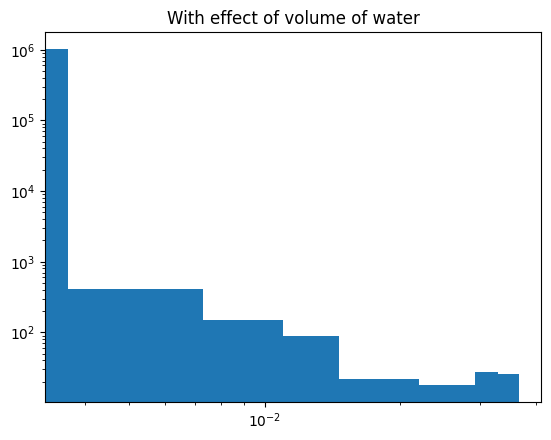

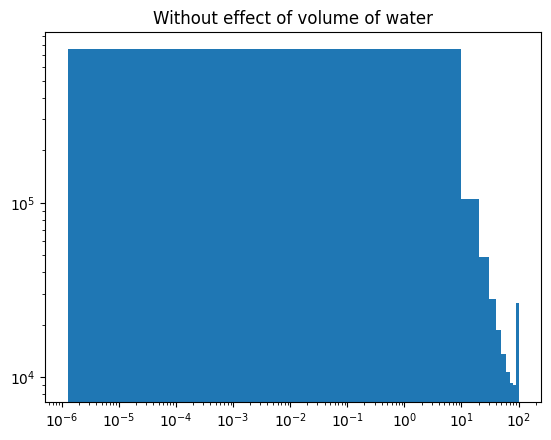

In [85]:
import matplotlib.pyplot as plt

#with effect of volume
plt.figure()
plt.title('With effect of volume of water')
plt.hist(np.ravel(lateral_flow_percentage_with_vol),bins=10)
np.shape(np.log(np.ravel(lateral_flow_percentage_with_vol)))
print(np.ravel(lateral_flow_percentage_with_vol))
plt.xscale('log')
plt.yscale('log')

#without effect of volume
plt.figure()
plt.title('Without effect of volume of water')
plt.hist(np.ravel(lateral_flow_percentage_without_vol),bins=10)
np.shape(np.log(np.ravel(lateral_flow_percentage_without_vol)))
plt.xscale('log')
plt.yscale('log')

#without effect of volume
print(np.ravel(lateral_flow_percentage))